# A pendulum video and autoencoder


In [1]:
import os
import argparse, sys
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import sys
syspath = 'SindyPendulum/'
if syspath not in sys.path:
    sys.path.append(syspath)
    
from sindy_library import SINDyLibrary

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Data Generation

In [3]:
def pend(y, t,):
    theta, omega = y
    dydt = [omega, - np.sin(theta)]
    return dydt

def pend_damp(y, t,):
    theta, omega = y
    dydt = [omega, - np.sin(theta)-0.1*omega]
    return dydt

def select_ics(theta0,omegaics0):
    ics = []
    for i in range(n_ics):
        for j in range(n_ics):
            lim = (np.abs((omega0[j]**2)/2 - np.cos(theta0[i])))
            if lim <  0.99 :
                ics.append((theta0[i],omega0[j]))
    return ics

def wrap_to_pi(z):
    z_mod = z % (2*np.pi)
    subtract_m = (z_mod > np.pi) * (-2*np.pi)
    return z_mod + subtract_m

def image_gen(ics):
    x = np.linspace(-1.5, 1.5, NX)
    y = np.linspace(-1.5, 1.5, NY)
    xx,yy = np.meshgrid(x, y)


    data = np.empty([len(ics), len(t), len(x), len(y)],dtype = np.float32)
    data2 = np.empty([len(ics), len(t), len(x), len(y)],dtype = np.float32)


    for idx in range(len(ics)):
        if(idx%100==0): print(idx,' su ', len(ics))
        y0 = [ics[idx][0], ics[idx][1]]
        sol = odeint(pend, y0,t)
        theta = sol[:,0]
        omega = sol[:,1]

        temp = []
        for i in range(len(theta)):
            z = np.exp(- 20 *((xx - np.cos(theta[i] + np.pi/2))*(xx - 
                np.cos(theta[i] +np.pi/2))) - 20 * ((yy -np.sin(theta[i]+np.pi/2))*(yy -np.sin(theta[i]+np.pi/2))))
            z = ((z - np.min(z))/(np.max(z)-np.min(z)))
    
            temp.append(z)
        data[idx] = np.array(temp)
        
        temp = []
        for i in range(len(omega)):            
            exp = -20 * 2 * omega[i]*(np.cos(theta[i]+ np.pi/2) - np.sin(theta[i] + np.pi/2))
            z = np.exp(- 20 *((xx - np.cos(theta[i] + np.pi/2))*(xx - 
                np.cos(theta[i] +np.pi/2))) - 20 * ((yy -np.sin(theta[i]+np.pi/2))*(yy -np.sin(theta[i]+np.pi/2))))
            z = z * exp
            z = ((z - np.min(z))/(np.max(z)-np.min(z)))
            temp.append(z)
        data2[idx] = np.array(temp)
        
    return data,data2

In [4]:
n_ics = 80
    
#COSTANTI e PARAMETRI
ta = 0.
tb = 5.
dt = 0.1
# tb = 10
# dt = 0.1
NX = 51
NY = 51


t = np.arange(ta, tb ,dt)
theta0 = np.linspace(-np.pi,np.pi,n_ics)
omega0 = np.linspace(-2.1, 2.1,n_ics)

ics = select_ics(theta0,omega0)
data,data2 = image_gen(ics)


#questo reshape serve per mandare al autoencoder delle immagini flat
#TODO verifica che sia corretto questo rehsape --> dovrebb essere ok fatto prova su colab
X = data.reshape((len(ics) * len(t),NX * NY))
Xdot = data2.reshape((len(ics) * len(t),NX * NY))
X.shape

0  su  3724
100  su  3724
200  su  3724
300  su  3724
400  su  3724
500  su  3724
600  su  3724
700  su  3724
800  su  3724
900  su  3724
1000  su  3724
1100  su  3724
1200  su  3724
1300  su  3724
1400  su  3724
1500  su  3724
1600  su  3724
1700  su  3724
1800  su  3724
1900  su  3724
2000  su  3724
2100  su  3724
2200  su  3724
2300  su  3724
2400  su  3724
2500  su  3724
2600  su  3724
2700  su  3724
2800  su  3724
2900  su  3724
3000  su  3724
3100  su  3724
3200  su  3724
3300  su  3724
3400  su  3724
3500  su  3724
3600  su  3724
3700  su  3724


(186200, 2601)

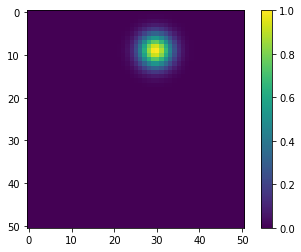

In [5]:
plt.imshow(X[123].reshape((51,51)))
plt.colorbar()

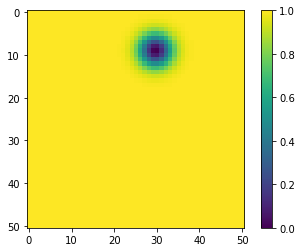

In [6]:
plt.imshow(Xdot[123].reshape((51,51)))
plt.colorbar()

In [7]:
Xdot[123]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [8]:
X = torch.from_numpy(X).float().to(device)
Xdot = torch.from_numpy(Xdot).float().to(device)
X.shape, Xdot.shape, X.dtype

(torch.Size([186200, 2601]), torch.Size([186200, 2601]), torch.float32)

In [9]:
val_size = round(X.shape[0] * 0.1)
train_size = X.shape[0] - val_size
train_size, val_size

(167580, 18620)

In [10]:
batch_size = 8192
my_dataset = TensorDataset(X,Xdot)

In [11]:
train_subset, val_subset = torch.utils.data.random_split(my_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_subset, shuffle=False, batch_size=batch_size)

# Network




In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight)
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc4 = nn.Linear(128,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight)
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=True,
            include_states=True,
            include_sin=True,
            include_cos=True,
            include_multiply_pairs=False, #non ho capito cosa é ma conta due volte le coppie  
            poly_order=2,
            include_sqrt=False,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)
        

        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = torch.float32,requires_grad=True,device = device))

        self.XI_coefficient_mask = torch.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = torch.float32, device=device)

    def configure_optimizers(self):
        learning_rate = 1e-4
        #return torch.optim.SGD(self.parameters(), lr=learning_rate)
        return torch.optim.Adam(self.parameters(), lr=learning_rate)


    def t_derivative(self,input, xdot, weights, biases, activation='sigmoid'):
        """
        Compute the first order time derivatives by propagating through the network.
        da[l]dt = xdot * da[l]dx = xdot * product(g'(w[l]a[l-1] + b[l])* w[l])
        Arguments:
            input - 2D tensorflow array, input to the network. Dimensions are number of time points
            by number of state variables.
            xdot - First order time derivatives of the input to the network. quello che conosciamo
            weights - List of tensorflow arrays containing the network weights
            biases - List of tensorflow arrays containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu' (exponential linear unit), 'relu' (rectified linear unit), 'sigmoid',
            or linear.

        Returns:
            dadt - Tensorflow array, first order time derivatives of the network output.
        """
        a   = input
        dadt = xdot #per le condizioni iniziali

        if activation == 'sigmoid':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.sigmoid(z)
                gprime = a * (1-a)
                dadt = gprime * torch.matmul(dadt, weights[i].T)
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            
        elif activation == 'relu':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.relu(z)
                dadt = (z > 0).float() * torch.matmul(dadt, weights[i].T)    
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
        return dadt #nel caso che ci serve dadt sará l output dell encoder ossia le latent variables!

    
    
    def compute_quantities(self,x,xdot):
    
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='sigmoid')                                               

        #print("propagazione sul decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot = self.t_derivative(z, zdot_hat, decoder_weight_list, decoder_biases_list, activation='sigmoid')    
        
        return xtilde, xtildedot, z, zdot, zdot_hat

    def loss_function(self, x, xdot, xtilde, xtildedot, zdot, zdot_hat,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 0


        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zdot, zdot_hat) 
        loss['sindy_regular_loss'] = torch.sum(torch.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_x'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    def forward(self, x, xdot):
        return self.compute_quantities(x, xdot)

In [13]:
input_size = X.shape[1]
latent_dim = 2

In [14]:
model = Autoencoder(input_size,latent_dim).to(device)

Encoder(
  (fc1): Linear(in_features=2601, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)
Linear(in_features=2601, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=2, bias=True)


In [15]:
model.SINDyLibrary.number_candidate_functions

10

In [20]:
#model.SINDyLibrary.get_feature_names()

# Parameters and Training


In [16]:
def sequential_threshold(t):
    if (t % seq_thres == 0 and t>1):
        model.XI_coefficient_mask = torch.abs(model.XI) > 0.1

In [17]:
def save_model(t):
    if SAVE == True:
        if t % saving_rate == 0 and t > 0:
            print('salvataggio a ',t,"epoche")
            f1 = path + 'model' + '_' + str(t) + 'epochs' + '.pt'
            torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.configure_optimizers().state_dict(),
            'loss': model.loss_function,
            'sindy_coefficients': model.XI,
            'coefficient_mask' : model.XI_coefficient_mask
            }, f1)
            
            XI = model.XI.cpu().detach().numpy()
            np.save(path + 'model' + '_' + str(t) + 'epochs' + '.npy',XI)


In [18]:
def print_model(t):
    f = open(path + 'model_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    for j in range(latent_dim):
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]
            if  coeff >= 0.1 and coeff != 0:
                #print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
                f.write(f"dz{j} = {coeff:.4f} {feature_list[i]}\n")
    f.close()

In [19]:
#training step for one epoch
def train_step(loss_list):
        
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, (X,Xdot) in enumerate (train_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)

        # Backpropagation
        optimizer = model.configure_optimizers()
        loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
            
    del loss_epoch,loss_dict,xtilde, xtildedot, z, zdot, zdot_hat,loss

In [20]:
def validation_step(loss_val_list):
    loss_val_epoch = []
    model.eval()     # Optional when not using Model Specific layer
    for batch, (X,Xdot) in enumerate (val_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)
        # validation loss 
        loss, _ = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss_val_epoch.append(loss.item())
        del  xtilde, xtildedot, z, zdot, zdot_hat,loss

    loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

In [21]:
def print_loss(t):
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

In [22]:
t = 1

In [23]:
VALIDATION = False
SAVE = True

epochs = 2000
path = '../model_zero/'

seq_thres = 100   # numero epoche ogni quanto fare seq thres

equation_rate = 100 #print delle equazioni trovate

saving_rate = 100 # numero epoche in cui salvo il modello e gli XI

loss_rate = 50  #print delle loss


In [ ]:
loss_list = {}
loss_list['recon_loss'] = []
loss_list['sindy_loss_x'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []
loss_val_list = []


while t <= epochs:
    print("epoch:",t)
    train_step(loss_list)
    
    validation_step(loss_val_list)
    
    print_loss(t)

    save_model(t)
    
    sequential_threshold(t)
    
    if t % equation_rate == 0 and t>1:
        print_model(t)
        data = pd.DataFrame.from_dict(loss_list)
        data.to_csv(path + 'data_'+str(t)+'epochs'+'.csv')
    t = t + 1
print("Done!")

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50

Epoch 50
-------------------------------
recon_loss of epoch 50: 6.869e-03
sindy_loss_x of epoch 50: 2.456e-01
sindy_loss_z of epoch 50: 1.816e+00
sindy_regular_loss of epoch 50: 1.924e+01
tot of epoch 50: 7.083e-03
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
ep

In [32]:
list(model.named_parameters())

[('XI',
  Parameter containing:
  tensor([[0.4375, 0.4209, 0.3701, 0.3860, 0.3989, 0.3715, 0.3485, 0.3876, 0.3717,
           0.4091],
          [0.9913, 0.9912, 0.9911, 0.9912, 0.9912, 0.9912, 0.9913, 0.9912, 0.9912,
           0.9913],
          [0.7874, 0.7868, 0.7729, 0.7755, 0.7793, 0.7734, 0.7677, 0.7731, 0.7674,
           0.7770],
          [0.4513, 0.4297, 0.3819, 0.3916, 0.4072, 0.3859, 0.3528, 0.3956, 0.3839,
           0.4132],
          [0.4363, 0.4199, 0.3730, 0.3764, 0.4048, 0.3673, 0.3367, 0.3791, 0.3619,
           0.3978],
          [0.3589, 0.3444, 0.2730, 0.2964, 0.3347, 0.2954, 0.2785, 0.2919, 0.2314,
           0.3192],
          [0.4046, 0.3734, 0.3357, 0.3536, 0.3719, 0.3413, 0.3317, 0.3615, 0.3221,
           0.3830],
          [0.4402, 0.4258, 0.3802, 0.3923, 0.4063, 0.3844, 0.3613, 0.3944, 0.3851,
           0.4128],
          [0.3338, 0.3058, 0.2723, 0.2867, 0.2933, 0.2960, 0.2685, 0.3009, 0.2657,
           0.3140],
          [0.4326, 0.4221, 0.3717, 0.3843

# LOAD models

In [ ]:
save_model(t)

In [ ]:
model.XI

In [ ]:
path = '../model/'
t = 1000

In [ ]:
print(f"Caricato il checkpoint all'epoca:{t} ")
model = Autoencoder(2601,2).to(device)
optimizer = model.configure_optimizers()

f1 = path + 'model' + '_' + str(t) + 'epochs' + '.pt'

checkpoint = torch.load(f1)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
print_model()

In [ ]:
data = pd.DataFrame.from_dict(loss_list)
data.to_csv('./data'+'_'+str(t)+'epochs'+'.csv')
for key in loss_list.keys():
    plt.plot(loss_list[key],label = key)
plt.plot(loss_val_list,label = 'validation')    
plt.legend(loc = 'best')
plt.title('Loss con batch size di '+str(batch_size))

In [ ]:
import csv

with open('./data'+'_'+str(t)+'epochs'+'.csv') as file:
    reader = csv.DictReader(file)
    for row in reader:
        print(row)